## HIERARCHICAL CLUSTERING USING A BOTTOM-UP APPROACH (AGGLOMERATIVE)
  
Adaptado de https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

## Motivation

Imagine a scenario in which you are part of a data science team that interfaces with the marketing department. Marketing has been gathering customer shopping data for a while, and they want to understand, based on the collected data, if there are similarities between customers. Those similarities divide customers into groups and having customer groups helps in the targeting of campaigns, promotions, conversions, and building better customer relationships.

   *Is there a way you could help determine which customers are similar? How many of them belong to the same group? And how many different groups there are?*

One way of answering those questions is by using a clustering algorithm, such as K-Means, DBSCAN, Hierarchical Clustering, etc. In general terms, clustering algorithms find similarities between data points and group them.

In this case, our marketing data is fairly small. We have information on only 200 customers. Considering the marketing team, it is important that we can clearly explain to them how the decisions were made based on the number of clusters, therefore explaining to them how the algorithm actually works.

Since our data is small and explicability is a major factor, we can leverage Hierarchical Clustering to solve this problem. This process is also known as Hierarchical Clustering Analysis (HCA).

   *One of the advantages of HCA is that it is interpretable and works well on small datasets.*

Another thing to take into consideration in this scenario is that HCA is an unsupervised algorithm. When grouping data, we won't have a way to verify that we are correctly identifying that a user belongs to a specific group (we don't know the groups). There are no labels for us to compare our results to. If we identified the groups correctly, it will be later confirmed by the marketing department on a day-to-day basis (as measured by metrics such as ROI, conversion rates, etc.).

Now that we have understood the problem we are trying to solve and how to solve it, we can start to take a look at our data!

### Retrieve Data

In [46]:
import pandas as pd
path_to_file = './data/shopping_data.csv'
customer_data = pd.read_csv(path_to_file)

After downloading the dataset, notice that it is a CSV (comma-separated values) file called shopping-data.csv. To make it easier to explore and manipulate the data, we'll load it into a DataFrame using Pandas:

In [47]:
customer_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Explore Data

Here, we see that marketing has generated a CustomerID, gathered the Genre, Age, Annual Income (in thousands of dollars), and a Spending Score going from 1 to 100 for each of the 200 customers. **When asked for clarification, they said that the values in the Spending Score column signify how often a person spends money in a mall on a scale of 1 to 100**. In other words, if a customer has a score of 0, this person never spends money, and if the score is 100, we have just spotted the highest spender.

Let's take a quick look at the distribution of this score to inspect the spending habits of users in our dataset. That's where the Pandas hist() method comes in to help:

<Axes: >

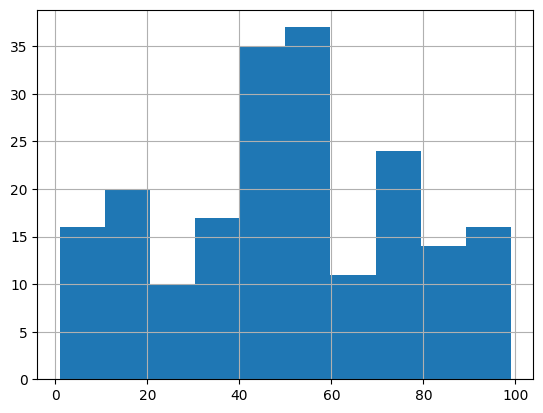

In [48]:
customer_data['Spending Score (1-100)'].hist()

By looking at the histogram we see that more than 35 customers have scores between 40 and 60, then less than 25 have scores between 70 and 80. 

So most of our customers are balanced spenders, followed by moderate to high spenders. We can also see that there is a line after 0, to the left of the distribution, and another line before 100, to the right of the distribution. 

These blank spaces probably mean that the distribution doesn't contain non-spenders, which would have a score of 0, and that there are also no high spenders with a score of 100.

<img src="./img/customer_spending_hist_analysis.webp" alt="drawing" width="650"/>

To verify if that is true, we can look at the minimum and maximum values of the distribution. Those values can be easily found as part of the descriptive statistics, so we can use the describe() method to get an understanding of other numeric values distributions:

In [49]:
# transpose() transposes the table, making it easier for us to compare values
customer_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


Our hypothesis is confirmed. The min value of the Spending Score is 1 and the max is 99. So we don't have 0 or 100 score spenders. 

Let's then take a look at the other columns of the transposed describe table. When looking at the mean and std columns, we can see that for Age the mean is 38.85 and the std is approximately 13.97. 

The same happens for Annual Income, with a mean of 60.56 and std 26.26, and for Spending Score with a mean of 50 and std of 25.82. For all features, the mean is far from the standard deviation, which indicates our data has high variability.

To understand better how our data varies, let's plot the Annual Income distribution

<Axes: >

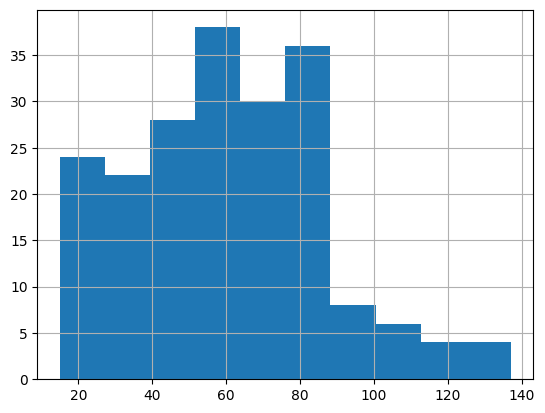

In [50]:
customer_data['Annual Income (k$)'].hist()

Notice in the histogram that most of our data, more than 35 customers, is concentrated near the number 60, on our mean, in the horizontal axis. But what happens as we move towards the ends of the distribution?   
When going towards the left, from the \\$60.560 mean, the next value we will encounter is \\$34.300, the mean (\\$ 60.560) minus the standard variation (\\$26.260). If we go further away to the left of our data distribution a similar rule applies, we subtract the standard variation (\\$26.260) from the current value (\\$34.300). Therefore, we'll encounter a value of \\$8.040. Notice how our data went from \\$60k to \\$8k quickly. It is "jumping" \\$26.260 each time, varying a lot, and that is why we have such high variability. 

<img src="./img/annual_income.webp" alt="drawing" width="650"/>

_The variability and the size of the data are important in clustering analysis because distance measurements of most clustering algorithms are sensitive to data magnitudes. The difference in size can change the clustering results by making one point seem closer or more distant to another than it actually is, distorting the actual grouping of data._

In [51]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Here, we can see that there are no null values in the data and that we have only one categorical column - Genre. At this stage, it is important that we have in mind what features seem interesting to be added to the clustering model. If we want to add the Genre column to our model, we will need to transform its values from categorical to numerical.

In [52]:
customer_data.Genre.value_counts(normalize = True)

Genre
Female    0.56
Male      0.44
Name: proportion, dtype: float64

Until now, all features but Age, have been briefly explored. In what concerns Age, it is usually interesting to divide it into bins to be able to segment customers based on their age groups. If we do that, we would need to transform the age categories into one number before adding them to our model. That way, instead of using the category 15-20 years, we would count how many customers there are in the 15-20 category, and that would be a number in a new column called 15-20.

In this guide, we present only brief exploratory data analysis. But you can go further and you should go further. You can see if there are income differences and scoring differences based on genre and age.

<Axes: >

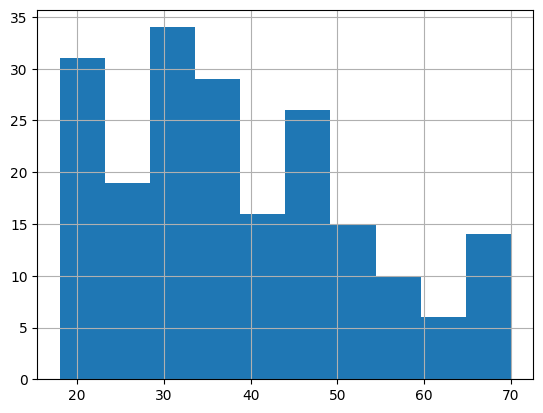

In [53]:
customer_data.Age.hist()

In [54]:
# Debuggear
#customer_data.corr()

In [55]:
# Explicar correlación con CustomerID

### Encoding Variables and Feature Engineering

Let's start by dividing the Age into groups that vary in 10, so that we have 20-30, 30-40, 40-50, and so on. 

Since our youngest customer is 15, we can start at 15 and end at 70, which is the age of the oldest customer in the data. 

Starting at 15, and ending at 70, we would have 15-20, 20-30, 30-40, 40-50, 50-60, and 60-70 intervals.

To group or bin Age values into these intervals, we can use the Pandas cut() method to cut them into bins and then assign the bins to a new Age Groups column:

In [56]:
intervals = [15, 20, 30, 40, 50, 60, 70]
col = customer_data['Age']
customer_data['Age Groups'] = pd.cut(x=col, bins=intervals)

# To be able to look at the result stored in the variable
customer_data['Age Groups'] 

0      (15, 20]
1      (20, 30]
2      (15, 20]
3      (20, 30]
4      (30, 40]
         ...   
195    (30, 40]
196    (40, 50]
197    (30, 40]
198    (30, 40]
199    (20, 30]
Name: Age Groups, Length: 200, dtype: category
Categories (6, interval[int64, right]): [(15, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70]]

Notice that when looking at the column values, there is also a line that specifies we have 6 categories and displays all the binned data intervals. This way, we have categorized our previously numerical data and created a new Age Groups feature.

And how many customers do we have in each category? We can quickly know that by grouping the column and counting the values with groupby() and count():

In [57]:
customer_data.groupby('Age Groups')['Age Groups'].count()

C:\Users\Jonatan\AppData\Local\Temp\ipykernel_18360\1439608483.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_data.groupby('Age Groups')['Age Groups'].count()


Age Groups
(15, 20]    17
(20, 30]    45
(30, 40]    60
(40, 50]    38
(50, 60]    23
(60, 70]    17
Name: Age Groups, dtype: int64

It is easy to spot that most customers are between 30 and 40 years of age, followed by customers between 20 and 30 and then customers between 40 and 50. This is also good information for the Marketing department.

At the moment, we have two categorical variables, Age and Genre, which we need to transform into numbers to be able to use in our model. 

There are many different ways of making that transformation - we will use the Pandas get_dummies() method that creates a new column for each interval and genre and then fill its values with 0s and 1s- this kind of operation is called one-hot encoding. Let's see how it looks:

In [58]:
# The _oh means one-hot
customer_data_oh = pd.get_dummies(customer_data)
# Display the one-hot encoded dataframe
customer_data_oh 

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Genre_Female,Genre_Male,"Age Groups_(15, 20]","Age Groups_(20, 30]","Age Groups_(30, 40]","Age Groups_(40, 50]","Age Groups_(50, 60]","Age Groups_(60, 70]"
0,1,19,15,39,False,True,True,False,False,False,False,False
1,2,21,15,81,False,True,False,True,False,False,False,False
2,3,20,16,6,True,False,True,False,False,False,False,False
3,4,23,16,77,True,False,False,True,False,False,False,False
4,5,31,17,40,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,35,120,79,True,False,False,False,True,False,False,False
196,197,45,126,28,True,False,False,False,False,True,False,False
197,198,32,126,74,False,True,False,False,True,False,False,False
198,199,32,137,18,False,True,False,False,True,False,False,False


In [59]:
# Hacerlo con sklearn

The advantage of one-hot encoding is the simplicity in representing the column values, it is straightforward to understand what is happening - while the disadvantage is that we have now created 8 additional columns, to sum up with the columns we already had.



__Warning: If you have a dataset in which the number of one-hot encoded columns exceeds the number of rows, it is best to employ another encoding method to avoid data dimensionality issues.__


One-hot encoding also adds 0s to our data, making it more sparse, which can be a problem for some algorithms that are sensitive to data sparsity.

For our clustering needs, one-hot encoding seems to work. But we can plot the data to see if there really are distinct groups for us to cluster.

### Plotting Each Pair of Data

Since plotting 10 dimensions is a bit impossible, we'll opt to go with the second approach - we'll plot our initial features. We can choose two of them for our clustering analysis. One way we can see all of our data pairs combined is with a Seaborn pairplot():

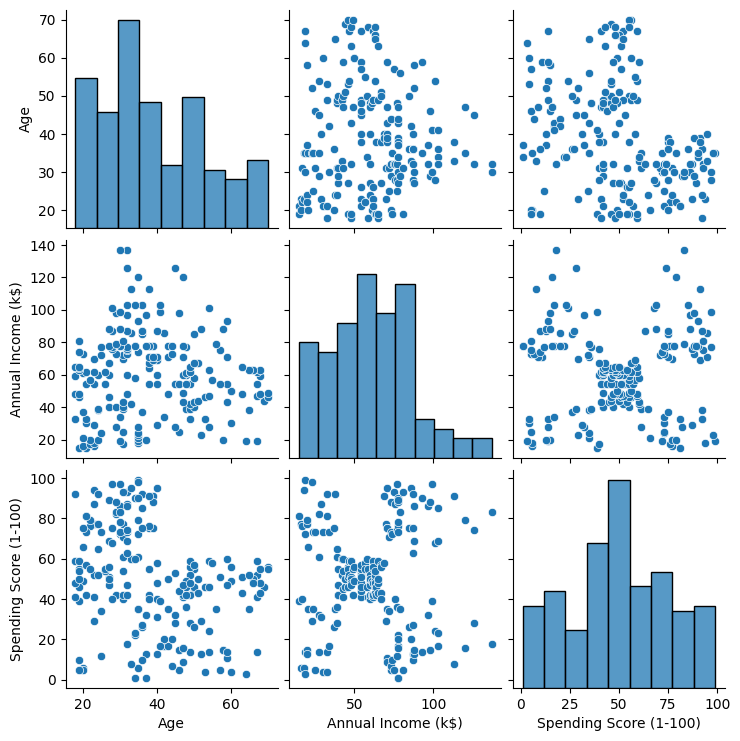

In [60]:
import seaborn as sns

# Dropping CustomerID column from data 
customer_data = customer_data.drop('CustomerID', axis=1)

sns.pairplot(customer_data)

At a glance, we can spot the scatterplots that seem to have groups of data. One that seems interesting is the scatterplot that combines Annual Income and Spending Score. Notice that there is no clear separation between other variable scatterplots. At the most, we can maybe tell that there are two distinct concentrations of points in the Spending Score vs Age scatterplot.

Both scatterplots consisting of Annual Income and Spending Score are essentially the same. We can see it twice because the x and y-axis were exchanged. By taking a look at any of them, we can see what appears to be five different groups. Let's plot just those two features with a Seaborn scatterplot() to take a closer look:

<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

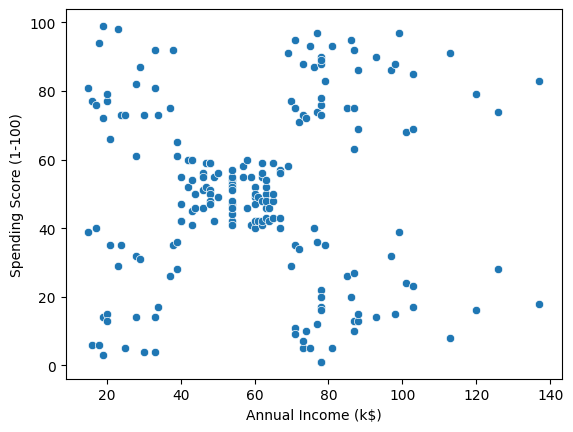

In [61]:
sns.scatterplot(x=customer_data['Annual Income (k$)'],
                y=customer_data['Spending Score (1-100)'])


By looking closer, we can definitely distinguish 5 different groups of data. It seems our customers can be clustered based on how much they make in a year and how much they spend. 

This is another relevant point in our analysis. It is important that we are only taking two features into consideration to group our clients. Any other information we have about them is not entering the equation. 

This gives the analysis meaning - if we know how much a client earns and spends, we can easily find the similarities we need.

<img src="./img/zoom_on_potential_clusters.webp" alt="drawing" width="650"/>

That's great! So far, we already have two variables to build our model. Besides what this represents, it also makes the model simpler, parsimonious, and more explainable.

## Visualizing Hierarchical Structure with Dendrograms

So far, we have explored the data, one-hot encoded categorical columns, decided which columns were fit for clustering, and reduced data dimensionality. The plots indicate we have 5 clusters in our data, but there's also another way to visualize the relationships between our points and help determine the number of clusters - by creating a dendrogram (commonly misspelled as dendogram). Dendro means tree in Latin.

The dendrogram is a result of the linking of points in a dataset. It is a visual representation of the hierarchical clustering process. And how does the hierarchical clustering process work? Well... **it depends - probably an answer you've already heard a lot in Data Science** (sororidad en la incertidumbre).

### Understanding Hierarchical Clustering

When the **Hierarchical Clustering Algorithm (HCA)** starts to link the points and find clusters, it can first split points into 2 large groups, and then split each of those two groups into smaller 2 groups, having 4 groups in total, which is the **divisive** and **top-down approach**.

Alternatively, it can do the opposite - it can look at all the data points, find 2 points that are closer to each other, link them, and then find other points that are the closest ones to those linked points and keep building the 2 groups from **the bottom-up**. Which is the **agglomerative** approach we will develop.

### Steps to Perform Agglomerative Hierarchical Clustering

To make the agglomerative approach even clear, there are steps of the Agglomerative Hierarchical Clustering (AHC) algorithm:

     1. At the start, treat each data point as one cluster. Therefore, the number of clusters at the start will be K - while K is an integer representing the number of data points.
    2. Form a cluster by joining the two closest data points resulting in K-1 clusters.
    3. Form more clusters by joining the two closest clusters resulting in K-2 clusters.
    4. Repeat the above three steps until one big cluster is formed.


_If you invert the steps of the ACH algorithm, going from 4 to 1 - those would be the steps to **Divisive Hierarchical Clustering (DHC)**_

Notice that HCAs can be either divisive and top-down, or agglomerative and bottom-up. The top-down DHC approach works best when you have fewer, but larger clusters, hence it's more computationally expensive. 

On the other hand, the bottom-up AHC approach is fitted for when you have many smaller clusters. It is computationally simpler, more used, and more available.

Let's plot our customer data dendrogram to visualize the hierarchical relationships of the data. This time, we will use the scipy library to create the dendrogram for our dataset:

In [62]:
customer_data_oh.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Genre_Female,Genre_Male,"Age Groups_(15, 20]","Age Groups_(20, 30]","Age Groups_(30, 40]","Age Groups_(40, 50]","Age Groups_(50, 60]","Age Groups_(60, 70]"
0,1,19,15,39,False,True,True,False,False,False,False,False
1,2,21,15,81,False,True,False,True,False,False,False,False
2,3,20,16,6,True,False,True,False,False,False,False,False
3,4,23,16,77,True,False,False,True,False,False,False,False
4,5,31,17,40,True,False,False,False,True,False,False,False


In [63]:
customer_data_oh.columns

Index(['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Genre_Female', 'Genre_Male', 'Age Groups_(15, 20]',
       'Age Groups_(20, 30]', 'Age Groups_(30, 40]', 'Age Groups_(40, 50]',
       'Age Groups_(50, 60]', 'Age Groups_(60, 70]'],
      dtype='object')

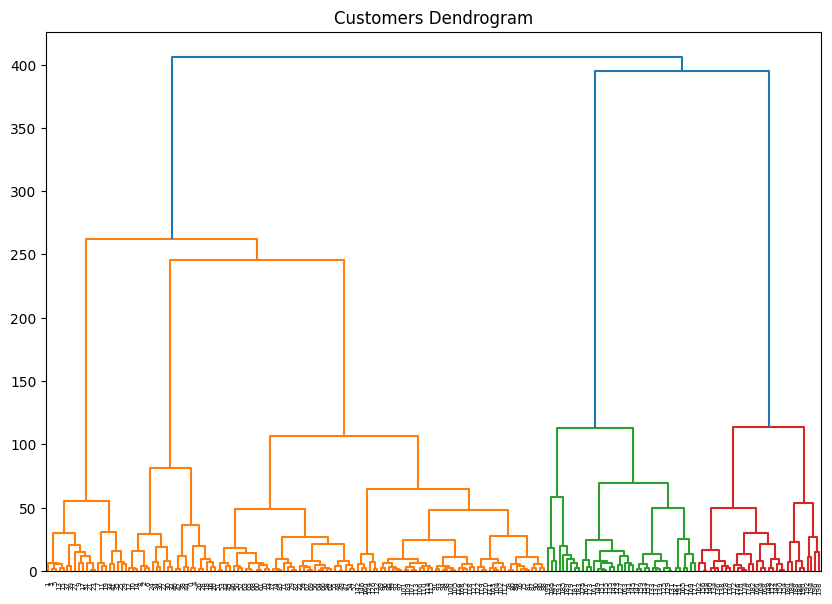

In [64]:
# Está en scipy!!1
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Customers Dendrogram")

# Selecting Annual Income and Spending Scores by index
selected_data = customer_data_oh.iloc[:, 2:4]
#selected_data = customer_data_oh[["Annual Income (k$)","Spending Score (1-100)"]]
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

In [82]:
# Elemento en la posición absoluta (iloc) 65 y 68 están a una distancia media 0 y forman un cluster de 2 elementos
clusters[0]

array([65., 68.,  0.,  2.])

In [97]:
# La sintaxis...
clusters[(clusters[:, 3:] == 4).ravel()]

array([[216.        , 218.        ,   2.23606798,   4.        ],
       [208.        , 230.        ,   2.54950976,   4.        ],
       [214.        , 215.        ,   3.16227766,   4.        ],
       [ 95.        , 224.        ,   3.29140294,   4.        ],
       [ 84.        , 238.        ,   3.67423461,   4.        ],
       [245.        , 246.        ,   4.        ,   4.        ],
       [ 72.        , 270.        ,   4.0824829 ,   4.        ],
       [172.        , 263.        ,   4.56435465,   4.        ],
       [206.        , 231.        ,   4.94974747,   4.        ],
       [236.        , 250.        ,   5.        ,   4.        ],
       [225.        , 242.        ,   5.38516481,   4.        ],
       [244.        , 255.        ,   5.70087713,   4.        ],
       [ 71.        , 269.        ,   6.13731755,   4.        ],
       [205.        , 287.        ,   6.51920241,   4.        ],
       [189.        , 315.        ,   9.32737905,   4.        ],
       [227.        , 268

In [105]:
# Quizá mejor así
dt_cluster = pd.DataFrame(clusters)

In the script above, we've generated the clusters and subclusters with our points, defined how our points would link (by applying the ward method), and how to measure the distance between points (by using the euclidean metric).

### Linkage Methods

There are many other linkage methods, by understanding more about how they work, you will be able to choose the appropriate one for your needs. Besides that, each of them will yield different results when applied. There is not a fixed rule in clustering analysis, if possible, study the nature of the problem to see which fits its best, test different methods, and inspect the results.

Some of the linkage methods are:

   

**Simple linkage:** also referred to as Nearest Neighbor (NN). The distance between clusters is defined by the distance between their closest members.
<img src="./img/single_linkage.png" alt="drawing" width="450"/>

**Complete linkage:** also referred to as Furthest Neighbor (FN), Farthest Point Algorithm, or Voor Hees Algorithm. The distance between clusters is defined by the distance between their furthest members. This method is computationally expensive.
<img src="./img/complete_linkage.png" alt="drawing" width="450"/>

**Average linkage:** also known as UPGMA (Unweighted Pair Group Method with Arithmetic mean). The percentage of the number of points of each cluster is calculated with respect to the number of points of the two clusters if they were merged.
    <img src="./img/average_linkage.png" alt="drawing" width="450"/>

**Centroid linkage:** also referred to as UPGMC (Unweighted Pair Group Method using Centroids). A point defined by the mean of all points (centroid) is calculated for each cluster and the distance between clusters is the distance between their respective centroids.
<img src="./img/centroid_linkage.png" alt="drawing" width="450"/>


**Ward linkage:** Also known as MISSQ (Minimal Increase of Sum-of-Squares). It specifies the distance between two clusters, computes the sum of squares error (ESS), and successively chooses the next clusters based on the smaller ESS. Ward's Method seeks to minimize the increase of ESS at each step. Therefore, minimizing error.
<img src="./img/ward_linkage.png" alt="drawing" width="700"/>


Regarding **distance** there are also several options (Euclidean, Manhattan, Minkowski, Chebyshev, Cosine, Jaccard, etc)

We have chosen Ward and Euclidean for the dendrogram because they are the most commonly used method and metric. They usually give good results since Ward links points based on minimizing the errors, and Euclidean works well in lower dimensions.

In this example, we are working with two features (columns) of the marketing data, and 200 observations or rows. Since the number of observations is larger than the number of features (200 > 2), we are working in a low-dimensional space.

_When the number of features (f) is larger than the number of observations (N) - mostly written as f >> N, it means that we have a high dimensional space._

We've already discussed metrics, linkages, and how each one of them can impact our results. Let's now continue the dendrogram analysis and see how it can give us an indication of the number of clusters in our dataset.

Finding an interesting number of clusters in a dendrogram is the same as finding the largest horizontal space that doesn't have any vertical lines (the space with the longest vertical lines). This means that there's more separation between the clusters.

We can draw a horizontal line that passes through that longest distance:

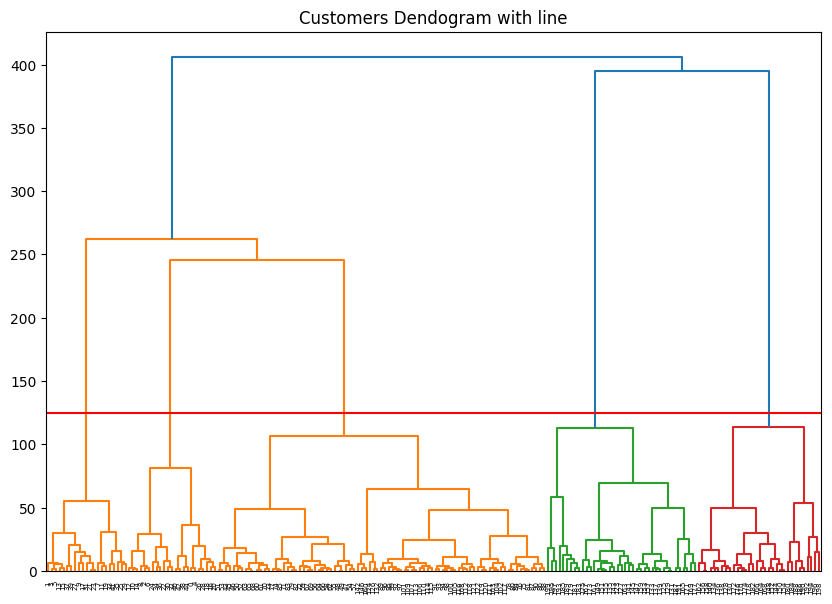

In [65]:
plt.figure(figsize=(10, 7))
plt.title("Customers Dendogram with line")
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 125, color = 'r', linestyle = '-')

In [77]:
clusters

array([[ 65.        ,  68.        ,   0.        ,   2.        ],
       [ 48.        ,  49.        ,   0.        ,   2.        ],
       [156.        , 158.        ,   0.        ,   2.        ],
       [129.        , 131.        ,   0.        ,   2.        ],
       [ 21.        ,  23.        ,   1.        ,   2.        ],
       [ 51.        ,  53.        ,   1.        ,   2.        ],
       [ 60.        ,  61.        ,   1.        ,   2.        ],
       [ 67.        ,  69.        ,   1.        ,   2.        ],
       [ 64.        ,  66.        ,   1.        ,   2.        ],
       [ 79.        ,  82.        ,   1.        ,   2.        ],
       [ 74.        ,  85.        ,   1.        ,   2.        ],
       [ 78.        ,  80.        ,   1.        ,   2.        ],
       [ 75.        ,  81.        ,   1.        ,   2.        ],
       [ 92.        ,  97.        ,   1.        ,   2.        ],
       [101.        , 109.        ,   1.        ,   2.        ],
       [107.        , 113

In [76]:
selected_data

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


After locating the horizontal line, we count how many times our vertical lines were crossed by it - in this example, 5 times. So 5 seems a good indication of the number of clusters that have the most distance between them.

**Note: The dendrogram should be considered only as a reference when used to choose the number of clusters. It can easily get that number way off and is completely influenced by the type of linkage and distance metrics. 

When conducting an in-depth cluster analysis, it is advised to look at dendrograms with different linkages and metrics and to look at the results generated with the first three lines in which the clusters have the most distance between them.**

### Implementing an Agglomerative Hierarchical Clustering

So far we've calculated the suggested number of clusters for our dataset that corroborate with our initial analysis 

Now we can create our agglomerative hierarchical clustering model using Scikit-Learn AgglomerativeClustering and find out the labels of marketing points with labels_:

In [66]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2], dtype=int64)

Text(0.5, 1.0, 'Labeled Customer Data')

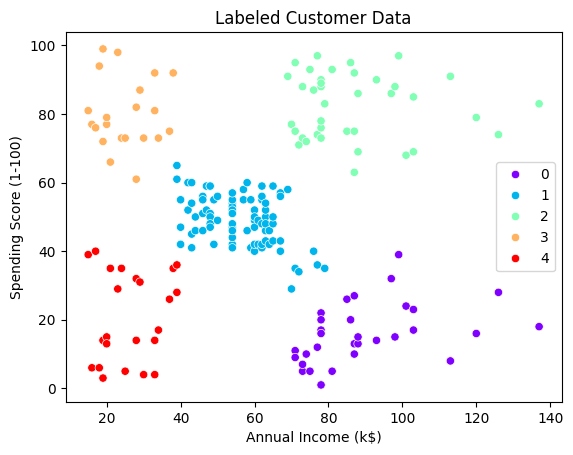

In [67]:
data_labels = clustering_model.labels_
sns.scatterplot(x='Annual Income (k$)', 
                y='Spending Score (1-100)', 
                data=selected_data, 
                hue=data_labels, palette = "rainbow").set_title('Labeled Customer Data')


This is our final clusterized data. You can see the color-coded data points in the form of five clusters.

The data points in the bottom right (label: 0, purple data points) belong to the customers with high salaries but low spending. These are the customers that spend their money carefully.

Similarly, the customers at the top right (label: 2, green data points), are the customers with high salaries and high spending. These are the type of customers that companies target.

The customers in the middle (label: 1, blue data points) are the ones with average income and average spending. The highest numbers of customers belong to this category. Companies can also target these customers given the fact that they are in huge numbers.

The customers in the bottom left (label: 4, red) are the customers that have low salaries and low spending, they might be attracted by offering promotions.

And finally, the customers in the upper left (label: 3, orange data points) are the ones with high income and low spending, which are ideally targeted by marketing.

## Conclusion

The clustering technique can be very handy when it comes to unlabeled data. Since most of the data in the real world are unlabeled and annotating the data has higher costs, clustering techniques can be used to label unlabeled data.

In this guide, we have brought a real data science problem, since clustering techniques are largely used in marketing analysis (and also in biological analysis). We have also explained many of the investigation steps to get to a good hierarchical clustering model and how to read dendrograms and questioned if PCA is a necessary step. Our main objective is that some of the pitfalls and different scenarios in which we can find hierarchical clustering are covered.

Happy clustering!

### Advantages of hierarchical clustering

   **Get the most similar observations to any given observations.** The main advantages of hierarchical clustering is that it provides detailed information about which observations are most similar to each other. This level of detail is not provided by many other algorithms, which generally just return the ID of the cluster a given observation belongs to. Hierarchical clustering is particularly useful in situations where you have a few observations you are particularly interested in and you want to be able to identify observations that are similar to those observations.
   
   **Not so sensitive to initialization conditions.** Another advantage of hierarchical clustering is that it is not sensitive to initialization conditions such as seeds that are set or the order of the dataset. You should generally get very similar results, and in some cases the same exact result, if you re-run your analysis with different initialization conditions.
   
   **Can be adapted to incorporate categorical variables.** Another advantage of hierarchical clustering is that it can be adapted to support situations where you have a mixture of numeric and categorical variables relatively easily. In order to do this, you must ensure that you are using a distance metrics that is appropriate for mixed data types such as Grower’s distance.
    
  **Well studied.** After k-means clustering, hierarchical clustering is probably the second most popular and well-studied type of clustering algorithm. That means that more of you coworkers will be familiar with it, which will make it easier for them to understand and contribute to analyses that use hierarchical clustering.
   
   **Less sensitive to outliers.** Hierarchical clustering is less sensitive to outliers than some other clustering algorithms. This means that the presence of a few outliers is not likely to affect the way the algorithm performs on the other data points. This is because outliers generally do not get added to a cluster until the end of the process when all of the other observations have already been handled (at least for agglomerative hierarchical clustering).
   
   Less stringent assumptions about cluster shape. Hierarchical clustering algorithms do not make as stringent assumptions about the shape of your clusters. Depending on the distance metric you use, some cluster shapes may be detected more easily than others, but there is more flexibility.

### Disadvantages of hierarchical clustering

   **Slow.** One disadvantage of hierarchical clustering is that it is relatively slow. Hierarchical clustering generally requires you to compute the pairwise distance between all of the observations in your dataset, so the number of computations required grows rapidly as the size of your dataset increases. 